In [1]:
# 범주형 데이터를 인코딩하여 학습 + randomized_search(cb 자체)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc
from scipy.stats import randint

In [3]:
df = pd.read_csv('../data/okcupid_preprocessed.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  59934 non-null  int64  
 1   sex                         59934 non-null  int64  
 2   orientation                 59934 non-null  int64  
 3   drugs                       59934 non-null  int64  
 4   education                   53310 non-null  float64
 5   height                      59934 non-null  float64
 6   job                         51739 non-null  object 
 7   last_online                 59934 non-null  object 
 8   sign                        59934 non-null  int64  
 9   age                         59934 non-null  int64  
 10  status                      59934 non-null  object 
 11  diet                        35547 non-null  object 
 12  location                    59934 non-null  object 
 13  pets                        400

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  59934 non-null  int64  
 1   sex                         59934 non-null  int64  
 2   orientation                 59934 non-null  int64  
 3   drugs                       59934 non-null  int64  
 4   education                   53310 non-null  float64
 5   height                      59934 non-null  float64
 6   job                         51739 non-null  object 
 7   last_online                 59934 non-null  object 
 8   sign                        59934 non-null  int64  
 9   age                         59934 non-null  int64  
 10  status                      59934 non-null  object 
 11  diet                        35547 non-null  object 
 12  location                    59934 non-null  object 
 13  pets                        400

In [6]:
df["last_online_dt"] = pd.to_datetime(df["last_online"])
ref_date = df["last_online_dt"].max() # 마지막 관측 시간

# churn 정의
THRESHOLD_DAYS = 30
df["inactive_days"] = (ref_date - df["last_online_dt"]).dt.days
df["churn"] = (df["inactive_days"] >= THRESHOLD_DAYS).astype(int)

print("ref_date:", ref_date)
print("churn rate:", df["churn"].mean())

ref_date: 2012-07-01 00:00:00
churn rate: 0.259235158674542


In [7]:
# X 데이터 정리
drop_cols = [
    "Unnamed: 0", "job", "last_online", "last_online_dt", "inactive_days", "churn",
     "status", "diet", "location", "pets", "city", "age"
]

drop_list = []

for col in drop_cols:
    if col in df.columns:
        drop_list.append(col)

X = df.drop(columns=drop_list)

# 라벨 데이터
y = df["churn"]

print("X shape:", X.shape)

X shape: (59934, 34)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
train_pool = Pool(X_train, y_train)

cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=0,
    verbose=0,
    iterations=800,
    od_type="Iter",
    od_wait=60,
    auto_class_weights="Balanced",
    depth=5,
    learning_rate=0.045, 
    l2_leaf_reg=1.85,
    rsm=0.65,
    random_strength=0,
    bagging_temperature=0.2
)

cb.fit(X_train, y_train)

In [ ]:
# train_pool = Pool(X_train, y_train)

# cb = CatBoostClassifier(
#     loss_function="Logloss",
#     eval_metric="AUC",
#     random_seed=0,
#     verbose=0,
#     iterations=2000,
#     od_type="Iter",
#     od_wait=60,
#     auto_class_weights="Balanced"
# )

# params = {
#     "depth": randint(4, 9),
#     "learning_rate": np.linspace(0.03, 0.15, 25),
#     "l2_leaf_reg": np.logspace(0, np.log10(50), 20),
#     "rsm": np.linspace(0.6, 1.0, 9),
#     "random_strength": np.linspace(0, 2, 9),
#     "bagging_temperature": np.linspace(0, 1, 6),
# }

# cb.randomized_search(params, X=train_pool, cv=3, n_iter=5, search_by_train_test_split=False, shuffle=True, stratified=True, verbose=True, plot=False)
# cb.get_params()
# cb.fit(X_train, y_train)

Training on fold [0/3]

bestTest = 0.6352462189
bestIteration = 159

Training on fold [1/3]

bestTest = 0.6307229629
bestIteration = 269

Training on fold [2/3]

bestTest = 0.6232253013
bestIteration = 194

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6293572	best: 0.6293572 (0)	total: 2m 36s	remaining: 10m 27s
Training on fold [0/3]

bestTest = 0.6359295607
bestIteration = 185

Training on fold [1/3]

bestTest = 0.6301687355
bestIteration = 183

Training on fold [2/3]

bestTest = 0.6235850219
bestIteration = 148

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6290488	best: 0.6293572 (0)	total: 4m 38s	remaining: 6m 57s
Training on fold [0/3]

bestTest = 0.6337873672
bestIteration = 52

Training on fold [1/3]

bestTest = 0.6296405524
bestIteration = 135

Training on fold [2/3]

bestTest = 0.6

In [ ]:
# cb.get_params()
# print(f"best_params: {cb.get_params()}") 

best_params: {'iterations': 2000, 'loss_function': 'Logloss', 'od_wait': 60, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 0, 'auto_class_weights': 'Balanced', 'eval_metric': 'AUC', 'bagging_temperature': 0.2, 'rsm': 0.65, 'random_strength': 0, 'depth': 5, 'learning_rate': 0.045, 'l2_leaf_reg': 1.85463487344428}


In [ ]:
# cb.fit(X_train, y_train)

In [11]:
proba = cb.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.05, 0.95, 91)
best_thres = None
best_f1 = -1

for t in thresholds:
    pred_t = (proba >= t).astype(int)
    f1 = f1_score(y_test, pred_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thres = t
        
print("best threshold:", best_thres, "best F1:", best_f1)
pred_best = (proba >= best_thres).astype(int)
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred_best, zero_division=0))

best threshold: 0.4099999999999999 best F1: 0.42577526235113783
ROC-AUC: 0.6157841600450483
              precision    recall  f1-score   support

           0       0.82      0.35      0.49     13320
           1       0.29      0.77      0.43      4661

    accuracy                           0.46     17981
   macro avg       0.55      0.56      0.46     17981
weighted avg       0.68      0.46      0.47     17981



In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sex                         59934 non-null  int64  
 1   orientation                 59934 non-null  int64  
 2   drugs                       59934 non-null  int64  
 3   education                   53310 non-null  float64
 4   height                      59934 non-null  float64
 5   sign                        59934 non-null  int64  
 6   body_type_average           59934 non-null  bool   
 7   body_type_curvy             59934 non-null  bool   
 8   body_type_fit               59934 non-null  bool   
 9   body_type_slim              59934 non-null  bool   
 10  smokes_smoke                59934 non-null  bool   
 11  smokes_sometime_smoke       59934 non-null  bool   
 12  drinks_heavy                59934 non-null  bool   
 13  drinks_moderate             599

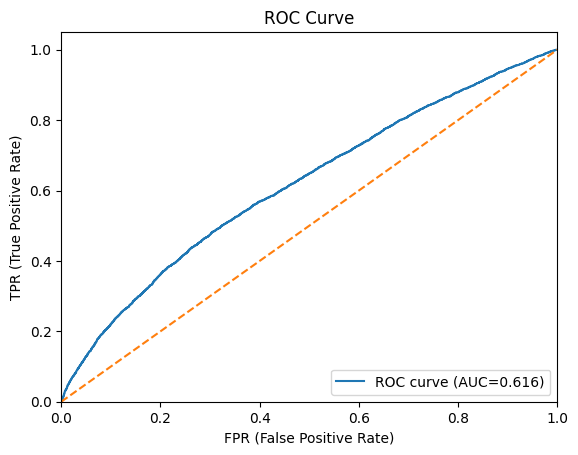

In [12]:
fpr, tpr, th = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# import shap

# X_train = X_train.astype('float')
# X_test = X_test.astype('float')

# explainer = shap.Explainer(cb, X_train)

# shap_values = explainer(X_test)

# shap.plots.bar(shap_values)

# shap.plots.beeswarm(shap_values)

In [ ]:
# %pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import joblib

# joblib.dump(cb, "../models/catboost_model.pkl")

['../models/catboost_model.pkl']